In [634]:
import pandas as pd
import numpy as np
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import seaborn as sb
import json
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import xgboost as xgb

In [635]:
config = {}

In [636]:
print(json.dumps(config, indent=4))

{}


# Load data

In [637]:
ttrain = pd.read_csv("train.csv")
ttest = pd.read_csv("test.csv")
label_column = "Survived"
print("Data loaded.")

Data loaded.


# Data overview

In [638]:
print(ttrain.columns.values)
print(len(ttrain.columns.values))

print(ttest.columns.values)
print(len(ttest.columns.values))

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']
12
['PassengerId' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare'
 'Cabin' 'Embarked']
11


In [639]:
ttrain.head()

# not number: Name, Sex, Ticket, Cabin, Embarked
# categorical: Sex, Embarked

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [640]:
ttrain.describe(include='O')

# Name/Ticket/Cabin需要处理
# Sex、Embarked需要转换分类类型

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Goldsmith, Master. Frank John William ""Frankie""",male,347082,C23 C25 C27,S
freq,1,577,7,4,644


In [642]:
ttrain.describe(include=np.number)

# Age: 缺失值

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [643]:
ttrain.info()
print('_'*40)
ttest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

In [644]:
for c in ttrain.columns:
    d = ttrain[c]
    du = d.unique()
    print(c + ".unique = ", len(du))

PassengerId.unique =  891
Survived.unique =  2
Pclass.unique =  3
Name.unique =  891
Sex.unique =  2
Age.unique =  89
SibSp.unique =  7
Parch.unique =  7
Ticket.unique =  681
Fare.unique =  248
Cabin.unique =  148
Embarked.unique =  4


# Analyze by pivoting feature

In [645]:
def get_mean_of_category(target_volumn, sort=True):
    group = ttrain[[target_volumn, label_column]].groupby([target_volumn], as_index=False)
    if sort:
        return group.mean().sort_values(by=label_column, ascending=False)
    else:
        return group.mean()

In [646]:
get_mean_of_category("Pclass")

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [647]:
get_mean_of_category("Sex")

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [648]:
get_mean_of_category("Embarked")

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


In [649]:
get_mean_of_category("SibSp", False)

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [650]:
get_mean_of_category("Parch", False)

,Parch,Survived
0,0,0.343658
1,1,0.550847
2,2,0.500000
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


### Visualize correlations

In [651]:
config["show_visual"] = True

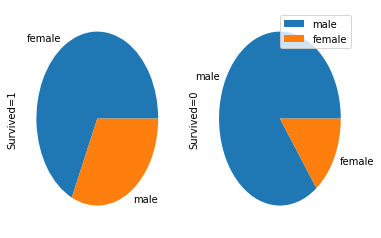

In [652]:
if config.get("show_visual"):
    plt.subplot2grid((1,2), (0,0))
    ttrain["Sex"][ttrain["Survived"] == 1].value_counts(normalize=True).plot(kind="pie", label="Survived=1")
    plt.subplot2grid((1,2), (0,1))
    ttrain["Sex"][ttrain["Survived"] == 0].value_counts(normalize=True).plot(kind="pie", label="Survived=0")
    plt.legend()

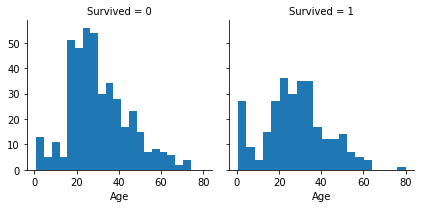

In [653]:
if config.get("show_visual"):
    g = sb.FacetGrid(ttrain, col='Survived', legend_out=True)
    g.map(plt.hist, 'Age', bins=20)

# 结论是，是否获救和Age不同阶段有关

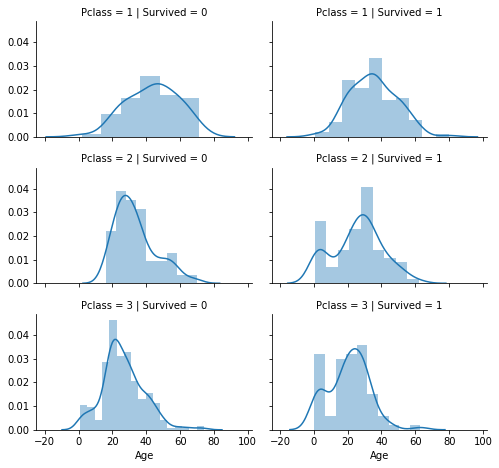

In [706]:
if config.get("show_visual"):
    g = sb.FacetGrid(ttrain, col='Survived', row='Pclass', height=2.2, aspect=1.6)
    g.map(sb.distplot, 'Age')

# 结论是，Pclass=3占比很多，同时也是最多没有生还的

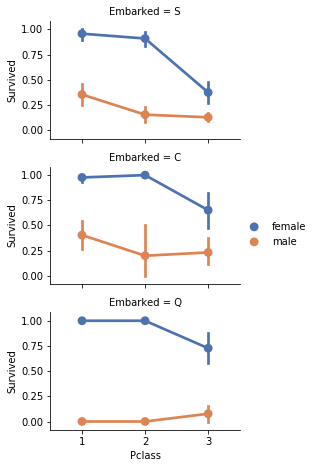

In [663]:
if config.get("show_visual"):
    g = sb.FacetGrid(ttrain, row='Embarked', height=2.2, aspect=1.6)
    g.map(sb.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep', order=[1,2,3], hue_order=["female", "male"])
    g.add_legend()

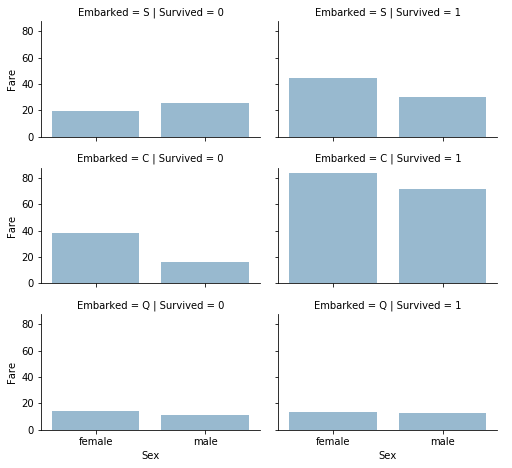

In [656]:
if config.get("show_visual"):
    g = sb.FacetGrid(ttrain, row='Embarked', col='Survived', height=2.2, aspect=1.6)
    g.map(sb.barplot, 'Sex', 'Fare', alpha=.5, ci=None, order=None)
    g.add_legend()

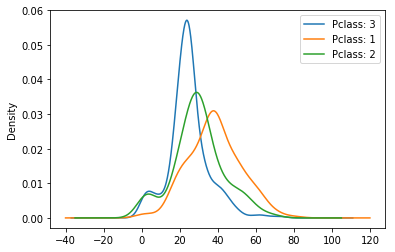

In [657]:
if config.get("show_visual"):
    for x in ttrain1["Pclass"].unique(): 
        ttrain1["Age"][ttrain1["Pclass"] == x].plot(kind="kde", label="Pclass: {}".format(x))
    plt.legend()

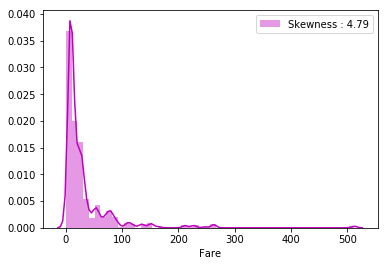

In [658]:
if config.get("show_visual"):
    g = sb.distplot(ttrain1["Fare"], color="m", label="Skewness : %.2f"%(ttrain1["Fare"].skew()))
    g = g.legend(loc="best")
    
# fare的值偏度很大，会对模型产生影响。使用log值减小偏度

# Data Analysis

In [673]:
import copy
ttrain1 = copy.deepcopy(ttrain)
ttest1 = copy.deepcopy(ttest)

config["data_dropped"] = False
config["replace_title_to_rare"] = False
config["title_to_ordinal"] = False
config["converting_sex_feature"] = False
config["create_family_size"] = False
config["converting_embark_feature"] = False

PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

### Extract title

In [387]:
# 提取title
def extract_title(d):
    d["Title"] = d["Name"].str.extract(' ([A-Za-z]+)\.', expand=False)

In [394]:
extract_title(ttrain1)
extract_title(ttest1)
ttest1["Title"].head()

0     Mr
1    Mrs
2     Mr
3     Mr
4    Mrs
Name: Title, dtype: object

In [390]:
pd.crosstab(ttest1['Title'], ttest1["Sex"])

Sex,female,male
Title,,
Col,0,2
Dona,1,0
Dr,0,1
Master,0,21
Miss,78,0
Mr,0,240
Mrs,72,0
Ms,1,0
Rev,0,2


In [391]:
rare_titles = ['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
def replace_title_to_rare(dataset):
    dataset['Title'] = dataset['Title'].replace(rare_titles, 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [392]:
if not config.get("replace_title_to_rare"):
    replace_title_to_rare(ttrain1)
    replace_title_to_rare(ttest1)
    config["replace_title_to_rare"] = True

In [395]:
ttest1['Title'].groupby(ttrain1["Title"]).count()

Title
Don         1
Dr          3
Master     23
Miss      101
Mme         1
Mr        228
Mrs        58
Rev         3
Name: Title, dtype: int64

In [396]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
def title_to_ordinal(dataset):
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

In [397]:
if not config.get("title_to_ordinal"):
    title_to_ordinal(ttrain1)
    title_to_ordinal(ttest1)
    config["title_to_ordinal"] = True

In [398]:
ttest1['Title'].groupby(ttest1["Title"]).count()

Title
0.0      7
1.0    240
2.0     78
3.0     72
4.0     21
Name: Title, dtype: int64

### Converting sex feature

In [399]:
def converting_sex_feature(dataset):
    dataset['Sex'] = dataset['Sex'].map({'female': 1, 'male': 0}).astype(int)

In [400]:
ttrain1['Sex'].groupby(ttrain1["Sex"]).count()

Sex
female    314
male      577
Name: Sex, dtype: int64

In [401]:
if not config.get("converting_sex_feature"):
    converting_sex_feature(ttrain1)
    converting_sex_feature(ttest1)
    config["converting_sex_feature"] = True

In [402]:
ttest1['Sex'].groupby(ttest1["Sex"]).count()

Sex
0    266
1    152
Name: Sex, dtype: int64

In [403]:
ttrain1.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,3.0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,3.0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,1.0


### Fill nan in  Age
PS: 划分Age band的过程感觉没有什么意义，RandomForest自己也会做划分，而且手动划分并没有证据证明更加优越。

In [404]:
def guess_age_by_gaussian(dataset):
    guess_ages = np.zeros((2, 3))
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # import random
            # age_guess = random.uniform(age_mean - age_std, age_mean + age_std)
            
            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            # guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            guess_ages[i,j] = age_guess
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[(dataset["Age"].isnull()) & (dataset["Sex"] == i) & (dataset["Pclass"] == j+1), 'Age'] = \
                guess_ages[i,j]
    
    dataset['Age'] = dataset['Age'].astype(int)

In [405]:
if not config.get("guess_age_by_gaussian"):
    guess_age_by_gaussian(ttrain1)
    guess_age_by_gaussian(ttest1)
    config["guess_age_by_gaussian"] = True

### Creating Family size

In [406]:
def create_family_size(dataset):
    dataset["FamilySize"] = dataset["SibSp"] + dataset["Parch"] + 1

In [409]:
if not config.get("create_family_size"):
    create_family_size(ttrain1)
    create_family_size(ttest1)
    config["create_family_size"] = True
    
ttrain1[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


### Converting Embark

In [411]:
ttest1["Embarked"].groupby(ttest1['Embarked']).count()

Embarked
C    102
Q     46
S    270
Name: Embarked, dtype: int64

In [412]:
def converting_embark_feature(dataset):
    dataset["Embarked"] = dataset["Embarked"].fillna(dataset["Embarked"].dropna().mode().iloc[0])
    dataset['Embarked'] = dataset['Embarked'].map({"Q": 2, 'S': 1, 'C': 0}).astype(int)

In [413]:
if not config.get("converting_embark_feature"):
    converting_embark_feature(ttrain1)
    converting_embark_feature(ttest1)
    config["converting_embark_feature"] = True

In [416]:
ttest1['Embarked'].groupby(ttest1["Embarked"]).count()

Embarked
0    102
1    270
2     46
Name: Embarked, dtype: int64

### Fill nan in Fare

In [417]:
ttrain1['Fare'].fillna(ttrain1['Fare'].dropna().median(), inplace=True)
ttest1['Fare'].fillna(ttest1['Fare'].dropna().median(), inplace=True)

### Dropping data

In [418]:
ttrain1.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,7.2500,NaN,1,1.0,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,PC 17599,71.2833,C85,0,3.0,2
2,3,1,3,"Heikkinen, Miss. Laina",1,26,0,0,STON/O2. 3101282,7.9250,NaN,1,2.0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,113803,53.1000,C123,1,3.0,2
4,5,0,3,"Allen, Mr. William Henry",0,35,0,0,373450,8.0500,NaN,1,1.0,1


In [420]:
if not config.get("data_dropped"):
    ttrain1 = ttrain1.drop(["PassengerId", "Name", "Cabin", "Ticket", "Parch", "SibSp"], axis=1)
    ttest1 = ttest1.drop(["PassengerId", "Name", "Cabin", "Ticket", "Parch", "SibSp"], axis=1)
    config["data_dropped"] = True

print(ttrain1.columns.values)
print(ttest1.columns.values)

['Survived' 'Pclass' 'Sex' 'Age' 'Fare' 'Embarked' 'Title' 'FamilySize']
['Pclass' 'Sex' 'Age' 'Fare' 'Embarked' 'Title' 'FamilySize']


### Summary

In [435]:
ttrain1.describe()
# ttest1.describe()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.352413,29.072952,32.204208,0.897868,1.589226,1.904602
std,0.486592,0.836071,0.477990,13.326339,49.693429,0.514624,0.923876,1.613459
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,2.000000,0.000000,21.000000,7.910400,1.000000,1.000000,1.000000
50%,0.000000,3.000000,0.000000,26.000000,14.454200,1.000000,1.000000,1.000000
75%,1.000000,3.000000,1.000000,36.000000,31.000000,1.000000,2.000000,2.000000
max,1.000000,3.000000,1.000000,80.000000,512.329200,2.000000,4.000000,11.000000


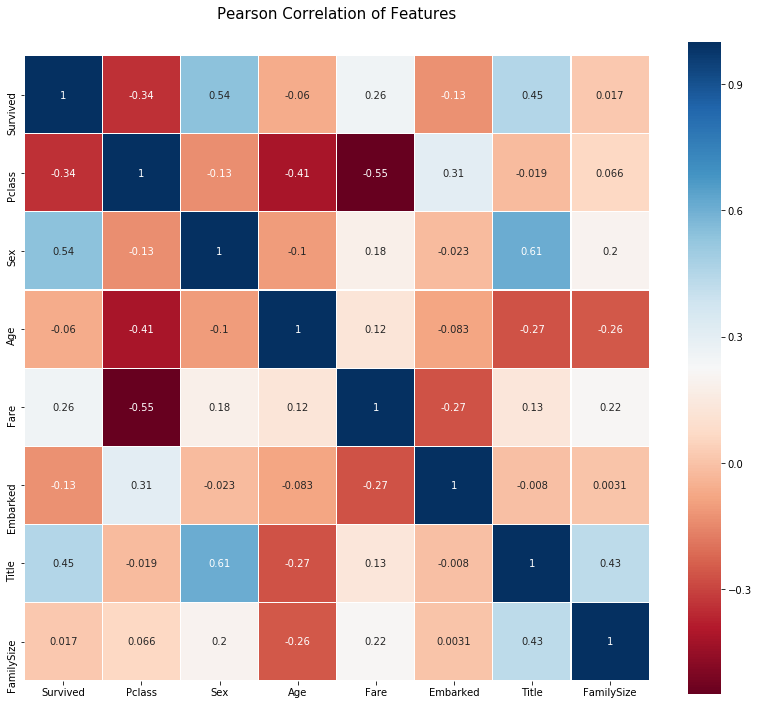

In [444]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sb.heatmap(ttrain1.astype(float).corr(),
           linewidths=0.1,
           vmax=1.0, 
           square=True, 
           cmap=colormap, 
           linecolor='white', 
           annot=True)

# Preperation

In [427]:
X_train = ttrain1.drop("Survived", axis=1).values
Y_train = ttrain1["Survived"].values
X_test = ttest1.values
print(X_train[:5])
print(Y_train[:5])
print(X_test[:5])
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

[[ 3.      0.     22.      7.25    1.      1.      2.    ]
 [ 1.      1.     38.     71.2833  0.      3.      2.    ]
 [ 3.      1.     26.      7.925   1.      2.      1.    ]
 [ 1.      1.     35.     53.1     1.      3.      2.    ]
 [ 3.      0.     35.      8.05    1.      1.      1.    ]]
[0 1 1 1 0]
[[ 3.      0.     34.      7.8292  2.      1.      1.    ]
 [ 3.      1.     47.      7.      1.      3.      2.    ]
 [ 2.      0.     62.      9.6875  2.      1.      1.    ]
 [ 3.      0.     27.      8.6625  1.      1.      1.    ]
 [ 3.      1.     22.     12.2875  1.      3.      3.    ]]
(891, 7)
(891,)
(418, 7)


In [449]:
SEED = 628
NFOLDS = 5
kf = KFold(n_splits= NFOLDS, shuffle=True, random_state=SEED)
# for train_index, test_index in kf.split(X_train):
#     X_tr, X_te = X_train[train_index], X_train[test_index]
#     Y_tr, Y_te = Y_train[train_index], Y_train[test_index]

# Sklearn models

In [500]:
class SklearnHelper(object):
    def __init__(self, classifier, seed=0, params=None):
        params = params or {}
        params['random_state'] = seed
        self._model = classifier(**params)

    def train(self, x_train, y_train):
        self._model.fit(x_train, y_train)

    def predict(self, x):
        return self._model.predict(x)
    
    def fit(self,x,y):
        return self._model.fit(x,y)
    
    def feature_importances(self):
        # print(self._model.fit(x,y).feature_importances_)
        print(self._model.feature_importances_)

In [501]:
def train_and_predict_process(model, X_train=X_train, Y_train=Y_train, X_test=X_test):
    ntrain = X_train.shape[0]
    ntest = X_test.shape[0]
    
    res_cv = np.zeros((ntrain,))
    res_test_each = np.empty((NFOLDS, ntest))
    accuracy = np.zeros(NFOLDS, )

    i = 0
    for train_index, test_index in kf.split(X_train):
        x_train, x_cv = X_train[train_index], X_train[test_index]
        y_train, y_cv = Y_train[train_index], Y_train[test_index]
        
        model.train(x_train, y_train)

        res_cv = model.predict(x_cv)
        binary_res_cv = (res_cv > 0.5).astype(np.int32)
        accuracy[i] = (binary_res_cv == y_cv).astype(np.int32).mean()
        
        res_test_each[i, :] = model.predict(X_test)
        
        i+=1

    res = np.zeros((ntest,))
    res[:] = res_test_each.mean(axis=0)
    return res_cv.reshape(-1, 1), res.reshape(-1, 1), accuracy

### SVM

In [548]:
from sklearn.svm import SVC
params = {
    "C": 0.1,
    "probability": True,
    "kernel": "linear",
    # "tol": 1e-5,
}
svc_ = SklearnHelper(SVC, SEED, params)
print(svc_._model)
res_svc = train_and_predict_process(svc_)
# print(res_svc[2])
print(res_svc[2].mean())

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=628, shrinking=True,
  tol=1e-05, verbose=False)
0.8215115184232001


In [585]:
output = True

if output:
    output_svc = (res_svc[1] > 0.5).astype(np.int32)
    singleSVM = pd.DataFrame({
        'PassengerId': np.arange(X_train.shape[0] + 1, X_train.shape[0]+predictions.shape[0] + 1), 
        'Survived': output_svc.squeeze() })
    singleSVM.to_csv("singleSVM.csv", index=False)

### RandomForest

In [549]:
from sklearn.ensemble import RandomForestClassifier
params = {
    'n_jobs': -1,
    'n_estimators': 1000,
    # 'warm_start': True, 
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'verbose': 0
}
rfc = SklearnHelper(RandomForestClassifier, SEED, params)
print(rfc._model)
res_rfc = train_and_predict_process(rfc)
# print(res_rfc[2])
print(res_rfc[2].mean())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=628, verbose=0, warm_start=False)
[0.84916201 0.85393258 0.81460674 0.80898876 0.78651685]
0.8226413909986817


In [588]:
output = True

if output:
    output_rfc = (res_rfc[1] > 0.5).astype(np.int32)
    singleRFC = pd.DataFrame({
        'PassengerId': np.arange(X_train.shape[0] + 1, X_train.shape[0]+predictions.shape[0] + 1), 
        'Survived': output_rfc.squeeze() })
    singleRFC.to_csv("singleRFC.csv", index=False)

### AdaBoost

In [555]:
from sklearn.ensemble import AdaBoostClassifier
params = {
    'n_estimators': 500,
    'learning_rate': 0.75
}
abc = SklearnHelper(AdaBoostClassifier, SEED, params)
print(abc._model)
res_abc = train_and_predict_process(abc)
# print(res_abc[2])
print(res_abc[2].mean())

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.75, n_estimators=500, random_state=628)
0.8080785889146946


In [589]:
output = True

if output:
    output_abc = (res_abc[1] > 0.5).astype(np.int32)
    singleABC = pd.DataFrame({
        'PassengerId': np.arange(X_train.shape[0] + 1, X_train.shape[0]+predictions.shape[0] + 1), 
        'Survived': output_abc.squeeze() })
    singleABC.to_csv("singleABC.csv", index=False)

### GradientBoost

In [566]:
from sklearn.ensemble import GradientBoostingClassifier
params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0,
    "learning_rate": 1,
}
gbc = SklearnHelper(GradientBoostingClassifier, SEED, params)
print(gbc._model)
res_gbc = train_and_predict_process(gbc)
# print(res_gbc[2])
print(res_gbc[2].mean())

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=2, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=628, subsample=1.0, verbose=0,
              warm_start=False)
0.8035779298223588


In [624]:
print(dir(gbc))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_model', 'feature_importances', 'fit', 'predict', 'train']


In [590]:
output = True

if output:
    output_gbc = (res_gbc[1] > 0.5).astype(np.int32)
    singleGBC = pd.DataFrame({
        'PassengerId': np.arange(X_train.shape[0] + 1, X_train.shape[0]+predictions.shape[0] + 1), 
        'Survived': output_gbc.squeeze() })
    singleGBC.to_csv("singleGBC.csv", index=False)

### ExtraTrees

In [569]:
from sklearn.ensemble import ExtraTreesClassifier
params = {
    'n_jobs': -1,
    'n_estimators':500,
    'max_features': "sqrt",
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}
etc = SklearnHelper(ExtraTreesClassifier, SEED, params)
print(etc._model)
res_etc = train_and_predict_process(etc)
print(res_etc[2])
print(res_etc[2].mean())

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=8, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=628, verbose=0, warm_start=False)
[0.8603352  0.84831461 0.82022472 0.81460674 0.78651685]
0.825999623375808


In [591]:
output = True

if output:
    output_etc = (res_etc[1] > 0.5).astype(np.int32)
    singleETC = pd.DataFrame({
        'PassengerId': np.arange(X_train.shape[0] + 1, X_train.shape[0]+predictions.shape[0] + 1), 
        'Survived': output_etc.squeeze() })
    singleETC.to_csv("singleETC.csv", index=False)

# Analysis result

In [507]:
rf_feature = rfc.feature_importances()
et_feature = etc.feature_importances()
ada_feature = abc.feature_importances()
gb_feature = gbc.feature_importances()

[0.10381857 0.24086883 0.09832218 0.1571506  0.01941587 0.29379385
 0.08663011]
[0.14606643 0.42766444 0.04111096 0.04984467 0.02388789 0.2404185
 0.07100713]
[0.016 0.018 0.248 0.634 0.02  0.022 0.042]
[0.03828405 0.01846247 0.39880849 0.43199377 0.02494473 0.04987912
 0.03762737]


In [ ]:
cols = ttrain1.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {
    'features': cols,
    'Random Forest feature importances': rf_features,
    'Extra Trees  feature importances': et_features,
    'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features,
})

# Stacking
### 使用上述4个ensemble算法结果作为input

In [508]:
base_predictions_train = pd.DataFrame({
    'RandomForest': res_rfc[0].ravel(),
    'ExtraTrees': res_etc[0].ravel(),
    'AdaBoost': res_abc[0].ravel(),
    'GradientBoost': res_gbc[0].ravel()
})
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0,0,0,0
1,0,0,0,0
2,1,1,1,1
3,0,0,0,0
4,0,0,0,0


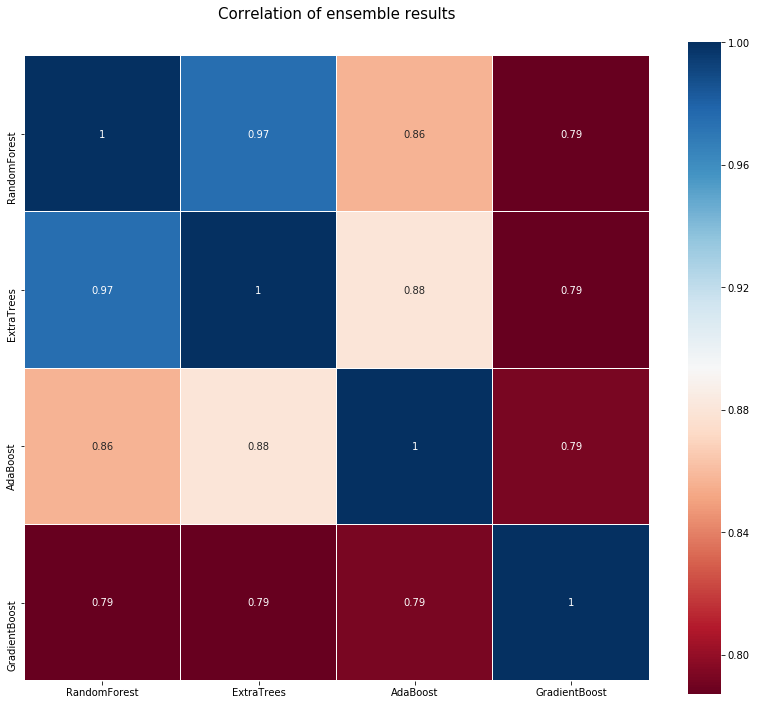

In [509]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Correlation of ensemble results', y=1.05, size=15)
sb.heatmap(base_predictions_train.astype(float).corr(),
           linewidths=0.1,
           vmax=1.0, 
           square=True, 
           cmap=colormap, 
           linecolor='white', 
           annot=True)

In [ ]:
new_X_train = np.vstack((
    etc.predict(X_train), rfc.predict(X_train), abc.predict(X_train), gbc.predict(X_train), svc_.predict(X_train))).T
new_X_test = np.vstack((
    etc.predict(X_test), etc.predict(X_test), abc.predict(X_test), gbc.predict(X_test), svc_.predict(X_test))).T
print(new_X_train.shape)
print(new_X_test.shape)
print(Y_train.shape)
print(Y_train[:10])

In [536]:
gbm = xgb.XGBClassifier(
    # learning_rate = 0.02,
    n_estimators = 2000,
    max_depth = 4,
    min_child_weight = 2,
    gamma=0.9,                        
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread= -1,
    scale_pos_weight=1)
gbm.fit(new_X_train, Y_train)
predictions = gbm.predict(new_X_test)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [539]:
StackingSubmission = pd.DataFrame({
    'PassengerId': np.arange(X_train.shape[0] + 1, X_train.shape[0]+predictions.shape[0] + 1), 
    'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)

# Average

In [586]:
res = (res_abc[1] + res_gbc[1] + res_etc[1] + res_svc[1] + res_rfc[1]) / 5.0
res = (res > 0.5).astype(np.int32)
valueAverage = pd.DataFrame({
    'PassengerId': np.arange(X_train.shape[0] + 1, X_train.shape[0]+predictions.shape[0] + 1), 
    'Survived': res.squeeze() })
valueAverage.to_csv("ValueAverage.csv", index=False)

In [587]:
res = np.zeros(res_abc[1].shape)
res += (res_abc[1] > 0.5).astype(np.int32)
res += (res_gbc[1] > 0.5).astype(np.int32)
res += (res_etc[1] > 0.5).astype(np.int32)
res += (res_svc[1] > 0.5).astype(np.int32)
res += (res_rfc[1] > 0.5).astype(np.int32)
res = (res > 2).astype(np.int32)
choiceAverage = pd.DataFrame({
    'PassengerId': np.arange(X_train.shape[0] + 1, X_train.shape[0]+predictions.shape[0] + 1), 
    'Survived': res.squeeze() })
valueAverage.to_csv("choiceAverage.csv", index=False)

# 提交结论
### ETC/RFC得分最高
两者单独提交，比stacking、average都要高<br>
给etc和rfc增加weight，得分又提高了一些

In [592]:
res = np.zeros(res_abc[1].shape)
res += (res_abc[1] > 0.5).astype(np.int32)
res += (res_gbc[1] > 0.5).astype(np.int32)
res += (res_etc[1] > 0.5).astype(np.int32) * 3
res += (res_svc[1] > 0.5).astype(np.int32)
res += (res_rfc[1] > 0.5).astype(np.int32) * 3
res = (res > 4).astype(np.int32)
weightedAverage = pd.DataFrame({
    'PassengerId': np.arange(X_train.shape[0] + 1, X_train.shape[0]+predictions.shape[0] + 1), 
    'Survived': res.squeeze() })
weightedAverage.to_csv("weightedAverage.csv", index=False)